In [18]:
from commons import input_iterator
import pandas as pd
import os
import datetime
import gzip
import glob
import h5py
import numpy as np
from tqdm import tqdm
from pathlib import Path
import shutil
import multiprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [2]:
# df_split = pd.read_csv("/mnt/nfs/niddk/ACT_final_randomization_5-13-2019.csv")

# test_ids = df_split[df_split['Randomization'] == 'test']['ID']

# all_data = glob.glob("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed/*/*")

# test_files = sorted([x for x in all_data if int(os.path.basename(x)) in set(test_ids)])

# out_root = "/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed_sampled"
# shutil.rmtree(out_root, ignore_errors=True)
# os.makedirs(out_root)
# partition = 8
# def apply_fn(x):
#     i = x[0]
#     test_dir = x[1]
#     out_dir = os.path.join(out_root, str(i % partition))
#     oid = os.path.basename(test_dir)
#     dirname = os.path.dirname(test_dir)
#     fnames = [name.split('.')[0] for name in os.listdir(test_dir) if not name.startswith('.')]
#     fnames.sort()
#     for i in range(len(fnames) - 1):
#         assert datetime.datetime.strptime(fnames[i+1], "%Y-%m-%d").date() - datetime.datetime.strptime(fnames[i], "%Y-%m-%d").date() == datetime.timedelta(days=1)
    
#     for i, fname in enumerate(fnames):
#         h5f = h5py.File(os.path.join(test_dir, '{}.h5'.format(fname)), 'r')
#         if i == 0:
#             timestamps = h5f.get('time')[:]
#             data = h5f.get('data')[:]
#             sleeping = h5f.get('sleeping')[:]
#             non_wear = h5f.get('non_wear')[:]
#             label = h5f.get('label')[:]
#         else:
#             timestamps = np.concatenate((timestamps, h5f.get('time')[:]))
#             data = np.concatenate((data, h5f.get('data')[:]))
#             sleeping = np.concatenate((sleeping, h5f.get('sleeping')[:]))
#             non_wear = np.concatenate((non_wear, h5f.get('non_wear')[:]))
#             label = np.concatenate((label, h5f.get('label')[:]))
#     labeld_indices = np.where(label != -1)[0]
#     sampled_indices = np.random.choice(labeld_indices, 100, replace=False) 
#     interval = 10
#     desired = 14 * 60
#     first_half = 7 * 60
#     need = desired // interval
#     for idx in sampled_indices:
#         sublabel = label[idx:idx + need]
#     #     all labeld and enough
#         if sublabel.shape[0] == need and np.where(sublabel == -1)[0].shape[0] == 0:
#             for offset in np.array([x for x in range(1, 8)]) * 6 + first_half // interval:
#     #             print(offset)
#                 sub_timestamps = timestamps[idx:idx + offset]
#                 sub_data = data[idx:idx + offset]
#                 sub_sleeping = sleeping[idx:idx + offset]
#                 sub_non_wear = non_wear[idx:idx + offset]
#                 sub_label = label[idx:idx + offset]
                
#                 name = "{}_{}_{}".format(oid, idx, offset)
#                 dummy_name = fnames[0] + '.h5'
#                 sample_out_dir = os.path.join(out_dir, name)
#                 Path(sample_out_dir).mkdir(parents=True, exist_ok=True)
#                 out_filename = os.path.join(sample_out_dir, dummy_name)
#                 h5f_out = h5py.File(out_filename, "w")
#                 h5f_out.create_dataset('time', data=sub_timestamps, chunks=True, maxshape=(None,))
#                 h5f_out.create_dataset('data', data=sub_data, chunks=True, maxshape=(None, 100, 3))
#                 h5f_out.create_dataset('non_wear', data=sub_non_wear, chunks=True, maxshape=(None,))
#                 h5f_out.create_dataset('sleeping', data=sub_sleeping, chunks=True, maxshape=(None,))
#                 h5f_out.create_dataset('label', data=sub_label, chunks=True, maxshape=(None,))
#                 h5f_out.close()

# pool = multiprocessing.Pool(processes=40)
# mapped_values = list(tqdm(
#     pool.imap_unordered(apply_fn, list(enumerate(test_files))), total=len(test_files)))
# pool.close()
# pool.join()

    

100%|██████████| 213/213 [23:57<00:00,  6.75s/it]


In [68]:
# h5f = h5py.File("/mnt/nfs/niddk/ACT_30HZ_CSV_preprocessed_sampled/7/151667_120933_48/2017-10-23.h5", 'r')

In [20]:
def read_file(predfile):
    filename = os.path.basename(predfile).split('.')[0]
    oid, index, offset = filename.split("_")
    index = int(index)
    offset = int(offset)
    df = pd.read_csv(predfile)
    df['oid'] = oid
    df['index'] = index
    df['offset'] = offset
    
    df_first = df.iloc[:42]
    df_second = df.iloc[42:]
    return df_first, df_second
#     df_all_list_first.append(df.iloc[:42])
#     df_all_list_sec.append(df.iloc[42:])
    

def get_acc(df_all_second):
    accs = {}
    summaries = {}
    offsets = sorted(df_all_second["offset"].unique())
    for off in offsets:
        df_score = df_all_second[df_all_second['offset'] == off]
        minute = (off - 42) // 6
        acc = accuracy_score(df_score['label'], df_score['prediction'])
        accs[minute] = acc
        summaries[minute] = classification_report(df_score['label'], df_score['prediction'], digits=4, output_dict=True)
        summaries[minute]["cm"] = confusion_matrix(df_score['label'], df_score['prediction'], labels=["sitting", "not-sitting"])
#         pred_mode = df_score["prediction"].mode()[0]
#         bias = df_score[df_score["label"] != pred_mode].shape[0] / df_score.shape[0]
#         variance = df_score[df_score["prediction"] != pred_mode].shape[0] / df_score.shape[0]
#         summaries[minute]["bias"] = bias
#         summaries[minute]["variance"] = variance
    return accs, summaries

def get_df_min(minute, df_all_second):
    start_index = (minute - 1) * 6
    end_index = minute * 6
    df_min = df_all_second[
        (start_index <= df_all_second['minute_index'])
        & (df_all_second['minute_index'] < end_index)]
    accs_min, summaries_min = get_acc(df_min)
    return accs_min, summaries_min

def read_cast(preds_root):
    

    all_preds = glob.glob(os.path.join(preds_root, "*.csv"))


    pool = multiprocessing.Pool(processes=40)
    df_list_all = list(tqdm(
        pool.imap_unordered(read_file, list(all_preds)), total=len(all_preds)))
    pool.close()
    pool.join()
    df_all_list_first = []
    df_all_list_second = []
    for df_first, df_second in df_list_all:
        df_all_list_first.append(df_first)
        df_all_list_second.append(df_second)
    df_all_first = pd.concat(df_all_list_first, ignore_index=True, sort=False)
    df_all_second = pd.concat(df_all_list_second, ignore_index=True, sort=False)
    df_all_second['correct'] = df_all_second['label'] == df_all_second['prediction']
    df_oid_groupby = df_all_second.groupby(["oid", "offset"]).agg({'correct': "sum", 'index': "count"})
    df_oid_groupby['acc'] = df_oid_groupby['correct'] / df_oid_groupby['index']
    df_7 = df_oid_groupby[df_oid_groupby.index.get_level_values(1) == 84]
    df_rel = df_oid_groupby.reset_index(level=1).merge(df_7[['acc']], on=['oid'], suffixes=('', '7'))
    df_rel['rel_acc'] = df_rel['acc'] / df_rel['acc7']
    df_rel_out = df_rel.groupby('offset').agg({'acc': "mean", 'rel_acc': "mean"})
    accs, summaries = get_acc(df_all_second)
        
    return df_all_first, df_all_second, df_rel_out, accs, summaries
    

In [3]:
preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_WRAP/CHAP_ALL_ADULTS"
df_all_first_wrap, df_all_second_wrap, df_rel_out_wrap, accs_wrap, summaries_wrap = read_cast(preds_root)

100%|██████████| 148953/148953 [03:39<00:00, 679.21it/s]


In [21]:
_, summaries_wrap = get_acc(df_all_second_wrap)

In [4]:
preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_ZERO/CHAP_ALL_ADULTS"
df_all_first_zero, df_all_second_zero, df_rel_out_zero, accs_zero, summaries_zero = read_cast(preds_root)

100%|██████████| 148953/148953 [03:37<00:00, 683.56it/s]


In [22]:
_, summaries_zero = get_acc(df_all_second_zero)

In [110]:
print(accuracy_score(df_all_first_zero['label'], df_all_first_zero['prediction'])) 

0.8344052598246874


In [22]:
summary_zero = classification_report(df_all_second_zero['label'], df_all_second_zero['prediction'], digits=4, output_dict=True)
print(summary_zero)

{'not-sitting': {'precision': 0.5402789968022511, 'recall': 0.7244440713350049, 'f1-score': 0.6189527588465515, 'support': 631331}, 'sitting': {'precision': 0.9362370291961519, 'recall': 0.8677888298481319, 'f1-score': 0.9007144015740812, 'support': 2943541}, 'accuracy': 0.842473800460548, 'macro avg': {'precision': 0.7382580129992016, 'recall': 0.7961164505915683, 'f1-score': 0.7598335802103164, 'support': 3574872}, 'weighted avg': {'precision': 0.8663098875952012, 'recall': 0.842473800460548, 'f1-score': 0.850954617261576, 'support': 3574872}}


In [23]:
summary_wrap = classification_report(df_all_second_wrap['label'], df_all_second_wrap['prediction'], digits=4, output_dict=True)
print(summary_wrap)

{'not-sitting': {'precision': 0.5209781364679347, 'recall': 0.7404895371841396, 'f1-score': 0.6116349506433698, 'support': 631331}, 'sitting': {'precision': 0.9388104647076245, 'recall': 0.8539700992783862, 'f1-score': 0.8943828172338596, 'support': 2943541}, 'accuracy': 0.8339291588621914, 'macro avg': {'precision': 0.7298943005877796, 'recall': 0.7972298182312629, 'f1-score': 0.7530088839386146, 'support': 3574872}, 'weighted avg': {'precision': 0.865020269808369, 'recall': 0.8339291588621914, 'f1-score': 0.8444488634132918, 'support': 3574872}}


In [ ]:
summary_first = classification_report(df_all_first['label'], df_all_first['prediction'])
print(summary_first)

In [ ]:
print(classification_report(df_all_first_zero['label'], df_all_first_zero['prediction'])) 

In [ ]:
print(accuracy_score(df_all_first_zero['label'], df_all_first_zero['prediction'])) 

In [113]:
accs_zero

{1: 0.9089007942102543,
 2: 0.8804494258815421,
 3: 0.8558698978126583,
 4: 0.8410306718674123,
 5: 0.8321522001347181,
 6: 0.8301011430152837,
 7: 0.8351952181784411}

In [ ]:
df_all_second_zero

In [120]:
print(df_all_second_zero[(df_all_second_zero["oid"] == "154558") & (df_all_second_zero["index"] == 116038)].to_string())

         segment            timestamp    label prediction     oid   index  offset  correct
0              0  2017-10-02 10:26:40  sitting    sitting  154558  116038      60     True
1              0  2017-10-02 10:26:50  sitting    sitting  154558  116038      60     True
2              0  2017-10-02 10:27:00  sitting    sitting  154558  116038      60     True
3              0  2017-10-02 10:27:10  sitting    sitting  154558  116038      60     True
4              0  2017-10-02 10:27:20  sitting    sitting  154558  116038      60     True
5              0  2017-10-02 10:27:30  sitting    sitting  154558  116038      60     True
6              0  2017-10-02 10:27:40  sitting    sitting  154558  116038      60     True
7              0  2017-10-02 10:27:50  sitting    sitting  154558  116038      60     True
8              0  2017-10-02 10:28:00  sitting    sitting  154558  116038      60     True
9              0  2017-10-02 10:28:10  sitting    sitting  154558  116038      60     True

In [122]:
18 * 10 / 60

3.0

In [124]:
df_all_second_zero[df_all_second_zero['label'] == "sitting"].count() / df_all_second_zero.count()

segment       0.823398
timestamp     0.823398
label         0.823398
prediction    0.823398
oid           0.823398
index         0.823398
offset        0.823398
correct       0.823398
dtype: float64

In [111]:
print(accuracy_score(df_all_second_zero['label'], df_all_second_zero['prediction'])) 

0.842473800460548


In [87]:
# preds_root = "/mnt/nfs/niddk/ACT_PREDICTIONS_SAMPLED_WRAP/CHAP_ALL_ADULTS"

# all_preds = glob.glob(os.path.join(preds_root, "*.csv"))


# pool = multiprocessing.Pool(processes=40)
# df_list_all = list(tqdm(
#     pool.imap_unordered(read_file, list(all_preds)), total=len(all_preds)))
# pool.close()
# pool.join()


# # df_all_sec = pd.DataFrame()
# # df_all_first = pd.DataFrame()
# # df_all_list_first = []
# # df_all_list_sec = []
# # for predfile in tqdm(all_preds):
# #     filename = os.path.basename(predfile).split('.')[0]
# #     oid, index, offset = filename.split("_")
# #     index = int(index)
# #     offset = int(offset)
# #     df = pd.read_csv(predfile)
# #     df['oid'] = oid
# #     df['index'] = index
# #     df['offset'] = offset
# #     df_all_list_first.append(df.iloc[:42])
# #     df_all_list_sec.append(df.iloc[42:])
# #     df_all_first = pd.concat([df_all_first, df.iloc[:42]], ignore_index=True, sort=False)
# #     df_all_sec = pd.concat([df_all_sec, df.iloc[42:]], ignore_index=True, sort=False)

# #     df_score = df[df['label'] != "no-label"]
# #     print(accuracy_score(df_score['label'], df_score['prediction']))

100%|██████████| 148953/148953 [03:17<00:00, 753.06it/s]


In [90]:
print(accuracy_score(df_all_first['label'], df_all_first['prediction'])) 

0.8344052598246874


In [91]:
print(accuracy_score(df_all_second['label'], df_all_second['prediction'])) 

0.8339291588621914


In [96]:
# df_oid_groupby = df_oid_groupby.reset_index()
# df_7 = df_oid_groupby[df_oid_groupby.index.get_level_values(1) == 84]

In [97]:
# df_rel = df_oid_groupby.reset_index(level=1).merge(df_7[['acc']], on=['oid'], suffixes=('', '7'))

In [98]:
# df_rel['rel_acc'] = df_rel['acc'] / df_rel['acc7']

In [99]:
# df_rel.groupby('offset').agg({'acc': "mean", 'rel_acc': "mean"})

,acc,rel_acc
offset,,
48,0.843489,1.011368
54,0.836876,1.002768
60,0.832949,0.997630
66,0.831603,0.995735
72,0.831724,0.995741
78,0.833763,0.998050
84,0.835199,1.000000


In [30]:
# df_oid_groupby['rel_acc'] = df_oid_groupby['acc'] / df_7['acc']

In [70]:
import matplotlib
import matplotlib.font_manager
from matplotlib import pyplot as plt
import seaborn as sns
class PlotterBase(object):
    def __init__(
            self,
            xlabel=None,
            ylabel=None,
            title=None,
            set_ticks=False,
            figsize=(5, 5)):
        self.fig, self.ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.set_title(title)
        self.set_ticks = set_ticks

    def plot(self, x, *args, **kwargs):
        self.ax.plot(x, linewidth=2, *args, **kwargs)
        if self.set_ticks:
            self.ax.set_xticks(x)

    def conclude(self, loc=None):
        self.ax.legend(ncol=2, loc=loc)
        self.fig.tight_layout()

    def save(self, path):
        save_fig(self.fig, path)
# font = {'size': 14}
# matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rc('pdf', fonttype=42)
def save_fig(fig, path):
    fig.savefig('{}.pdf'.format(path), transparent=True, bbox_inches='tight')
    fig.savefig('{}.eps'.format(path), transparent=True, bbox_inches='tight')
    fig.savefig('{}.png'.format(path), transparent=True,
                bbox_inches='tight', dpi=600)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


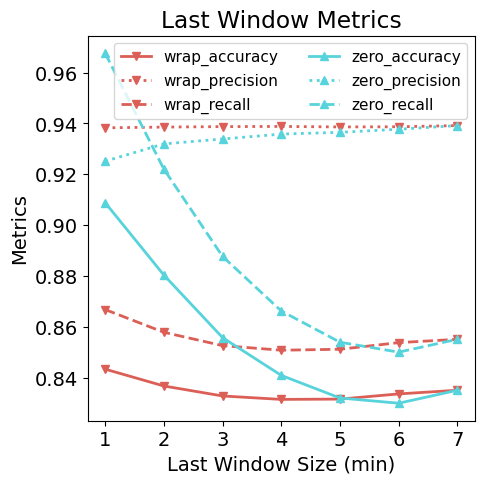

In [24]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', 'v--', '^-', '^:', '^--']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Metrics',
                       title='Last Window Metrics',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for metric in ["accuracy", "precision", "recall"]:
        if metric == "accuracy":
            ys = [summary[x][metric] for x in xs]
        elif metric == "recall":
            ys = [summary[x]["sitting"][metric] for x in xs]
        elif metric == "precision":
            ys = [summary[x]["sitting"][metric] for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_all_true")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


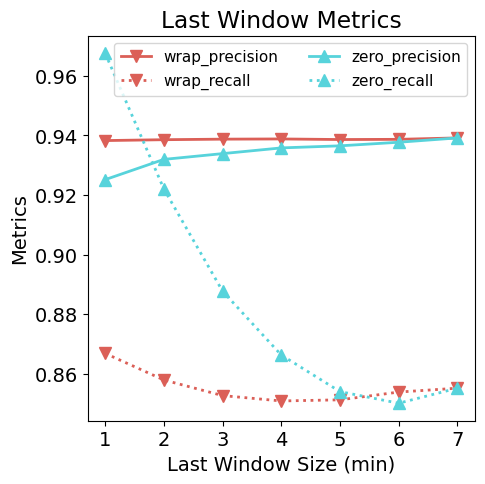

In [71]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', '^-', '^:']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Metrics',
                       title='Last Window Metrics',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for metric in ["precision", "recall"]:
        if metric == "recall":
            ys = [summary[x]["sitting"][metric] for x in xs]
        elif metric == "precision":
            ys = [summary[x]["sitting"][metric] for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=8, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_pr")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


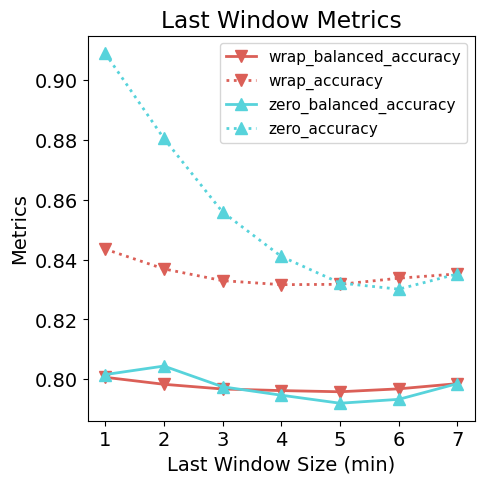

In [72]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', '^-', '^:']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Metrics',
                       title='Last Window Metrics',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for metric in ["accuracy", "balanced_accuracy"]:
        if metric == "balanced_accuracy":
            ys = [((summary[x]["sitting"]["recall"] + summary[x]["not-sitting"]["recall"]) / 2) for x in xs]
        elif metric == "accuracy":
            ys = [summary[x][metric] for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=8, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=1, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_accuracy_balanced")

In [45]:
for impute, summary in zip(["wrap", "zero"], [summaries_wrap, summaries_zero]):
    for k in range(1, 8):
        cm = summary[k]["cm"].flatten()
        print("Size: {}, Method: {}".format(k, impute))
        print("Precision: {}".format(cm[0] / (cm[0] + cm[2])))
        print("Recall: {}".format(cm[0] / (cm[0] + cm[1])))

Size: 1, Method: wrap
Precision: 0.9382858437425985
Recall: 0.8668962761402774
Size: 2, Method: wrap
Precision: 0.9385790051682948
Recall: 0.8579679805885292
Size: 3, Method: wrap
Precision: 0.9387635408993635
Recall: 0.852722371967655
Size: 4, Method: wrap
Precision: 0.9388312526566017
Recall: 0.850922711058264
Size: 5, Method: wrap
Precision: 0.9386353673551144
Recall: 0.8513039227062698
Size: 6, Method: wrap
Precision: 0.9387020780551384
Recall: 0.8539082028432804
Size: 7, Method: wrap
Precision: 0.9391785303331279
Recall: 0.8552157711198027
Size: 1, Method: zero
Precision: 0.925176256538549
Recall: 0.9675946187658173
Size: 2, Method: zero
Precision: 0.9319740322192834
Recall: 0.9220638960915384
Size: 3, Method: zero
Precision: 0.9339091100147113
Recall: 0.887765974314254
Size: 4, Method: zero
Precision: 0.9358271873241933
Recall: 0.8663400713436386
Size: 5, Method: zero
Precision: 0.9365240282523353
Recall: 0.8540584344557461
Size: 6, Method: zero
Precision: 0.9377252041588794
Reca

In [ ]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', '^-', '^:']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Percentage',
                       title='Last Window TP and FN',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for j, metric in enumerate(["TP", "FN", "FP", "TN"]):
        ys = [summary[x]["cm"].flatten()[j] / summary[x]["cm"].flatten().sum()  for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
# plot_e2e.ax.legend(ncol=2, fontsize=11)
# save_fig(plot_e2e.fig, "./figures/last_window_all_cm_tpfn")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


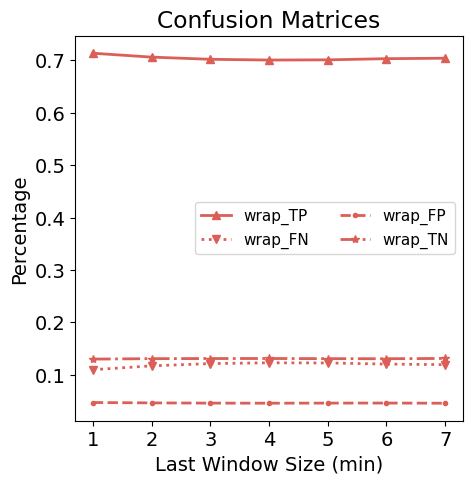

In [56]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['^-', 'v:', '.--', '*-.']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Percentage',
                       title='Confusion Matrices',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap'], [summaries_wrap]):
    xs = sorted(list(summary.keys()))
    for j, metric in enumerate(["TP", "FN", "FP", "TN"]):
        ys = [summary[x]["cm"].flatten()[j] / summary[x]["cm"].flatten().sum()  for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_all_cm_wrap")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


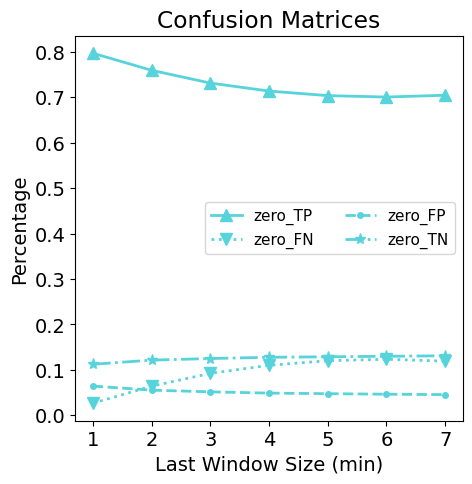

In [55]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['^-', 'v:', '.--', '*-.']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Percentage',
                       title='Confusion Matrices',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['zero'], [summaries_zero]):
    xs = sorted(list(summary.keys()))
    for j, metric in enumerate(["TP", "FN", "FP", "TN"]):
        ys = [summary[x]["cm"].flatten()[j] / summary[x]["cm"].flatten().sum()  for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=palette[1], ms=8, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_all_cm_zero")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


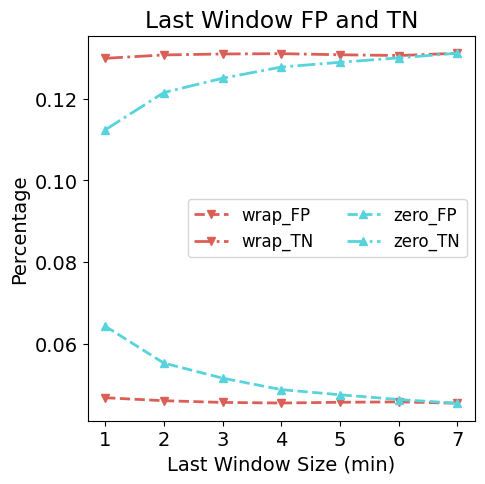

In [39]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v--', 'v-.', '^--', '^-.']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Percentage',
                       title='Last Window FP and TN',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for j, metric in enumerate(["FP", "TN"]):
        ys = [summary[x]["cm"].flatten()[j + 2] / summary[x]["cm"].flatten().sum()  for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=12)
save_fig(plot_e2e.fig, "./figures/last_window_all_cm_fptn")

In [ ]:
# TP: sitting predicted sitting
# FN: sitting predicted not-sitting
# FP: not-sitting predicted sitting
# TN: not-sitting predicted not-sitting
# To right = less padding = more true data

In [ ]:
# zero padding has a tendency to predict "sitting"

In [ ]:
summary[x]["cm"].flatten()

In [17]:
summary

{1: {'not-sitting': {'precision': 0.8081018648937969,
   'recall': 0.635545905707196,
   'f1-score': 0.7115112731602053,
   'support': 22568},
  'sitting': {'precision': 0.925176256538549,
   'recall': 0.9675946187658173,
   'f1-score': 0.9459101245866874,
   'support': 105106},
  'accuracy': 0.9089007942102543,
  'macro avg': {'precision': 0.8666390607161729,
   'recall': 0.8015702622365066,
   'f1-score': 0.8287106988734464,
   'support': 127674},
  'weighted avg': {'precision': 0.9044818718506817,
   'recall': 0.9089007942102543,
   'f1-score': 0.9044771524937566,
   'support': 127674},
  'bias': 0.17676269248241616,
  'variance': 0.1390181242852891},
 2: {'not-sitting': {'precision': 0.6543947001983206,
   'recall': 0.6867790005092664,
   'f1-score': 0.6701958708311275,
   'support': 45163},
  'sitting': {'precision': 0.9319740322192834,
   'recall': 0.9220638960915384,
   'f1-score': 0.9269924785057456,
   'support': 210185},
  'accuracy': 0.8804494258815421,
  'macro avg': {'prec

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


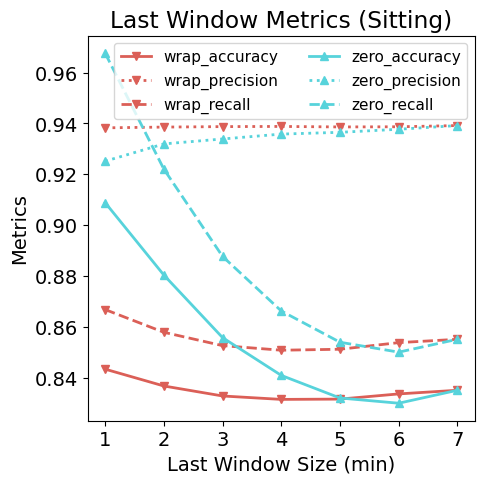

In [105]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', 'v--', '^-', '^:', '^--']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Metrics',
                       title='Last Window Metrics (Sitting)',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for metric in ["accuracy", "precision", "recall"]:
        if metric == "accuracy":
            ys = [summary[x][metric] for x in xs]
        else:
            ys = [summary[x]["sitting"][metric] for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_all_sitting")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


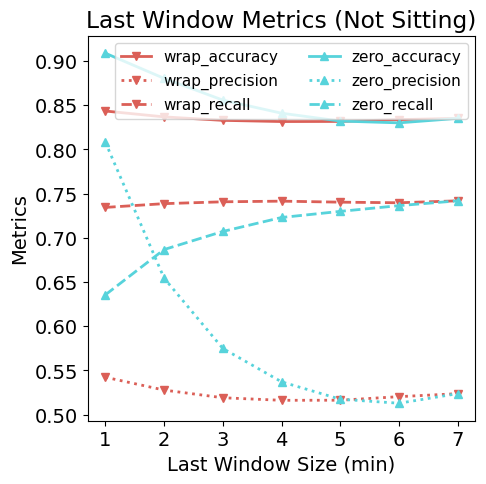

In [107]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', 'v--', '^-', '^:', '^--']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Metrics',
                       title='Last Window Metrics (Not Sitting)',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for metric in ["accuracy", "precision", "recall"]:
        if metric == "accuracy":
            ys = [summary[x][metric] for x in xs]
        else:
            ys = [summary[x]["not-sitting"][metric] for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_all_notsitting")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


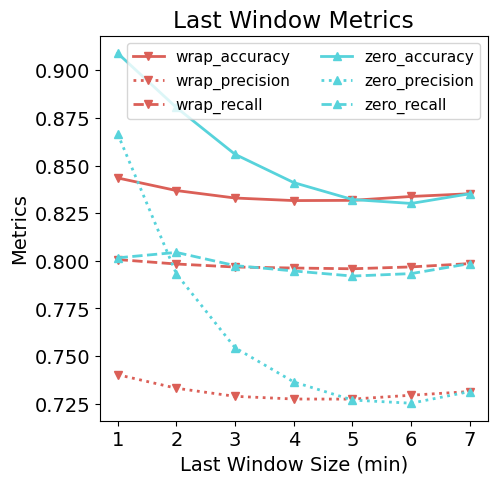

In [98]:
# xs = sorted(list(accs_wrap.keys()))
# ys = [accs_wrap[x] for x in xs]

palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', 'v--', '^-', '^:', '^--']
plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
                       ylabel='Metrics',
                       title='Last Window Metrics',
                       set_ticks=True)

i = 0
for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
    xs = sorted(list(summary.keys()))
    for metric in ["accuracy", "precision", "recall"]:
        if metric == "accuracy":
            ys = [summary[x][metric] for x in xs]
        else:
            ys = [summary[x]["macro avg"][metric] for x in xs]
        plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
        i += 1
plot_e2e.ax.legend(ncol=2, fontsize=11)
save_fig(plot_e2e.fig, "./figures/last_window_all")

In [79]:
summaries_wrap

{1: {'not-sitting': {'precision': 0.5422869294945198,
   'recall': 0.7344470046082949,
   'f1-score': 0.6239060470893795,
   'support': 22568},
  'sitting': {'precision': 0.9382858437425985,
   'recall': 0.8668962761402774,
   'f1-score': 0.9011794377271715,
   'support': 105106},
  'accuracy': 0.8434841862869495,
  'macro avg': {'precision': 0.7402863866185592,
   'recall': 0.8006716403742862,
   'f1-score': 0.7625427424082755,
   'support': 127674},
  'weighted avg': {'precision': 0.8682880094399946,
   'recall': 0.8434841862869495,
   'f1-score': 0.8521678466443066,
   'support': 127674},
  'bias': 0.16607084113780857,
  'variance': 0.25101290339905874},
 2: {'not-sitting': {'precision': 0.5277544886498458,
   'recall': 0.7387020348515377,
   'f1-score': 0.6156600047980217,
   'support': 45163},
  'sitting': {'precision': 0.9385790051682948,
   'recall': 0.8579679805885292,
   'f1-score': 0.8964649854095517,
   'support': 210185},
  'accuracy': 0.8368735999498723,
  'macro avg': {'p

In [1]:
# # xs = sorted(list(accs_wrap.keys()))
# # ys = [accs_wrap[x] for x in xs]

# palette = sns.color_palette("hls", 2)
# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
# line_fmts = ['v-', 'v--', '^-', '^--']
# plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
#                        ylabel='Bias-Variance',
#                        title='Last Window Bias-Variance Decomp.',
#                        set_ticks=True)

# i = 0
# for color, method, summary in zip(palette, ['wrap', 'zero'], [summaries_wrap, summaries_zero]):
#     xs = sorted(list(summary.keys()))
#     for metric in ["bias", "variance"]:
#         ys = [summary[x][metric] for x in xs]
#         plot_e2e.plot(xs, ys, line_fmts[i], color=color, ms=6, label="{}_{}".format(method, metric))
#         i += 1
# plot_e2e.ax.legend(ncol=2, fontsize=11)
# save_fig(plot_e2e.fig, "./figures/last_window_bv")

In [ ]:
# Bias = (1 if y≠E[ŷ ],0 otherwise.)
# Variance = P(ŷ ≠E[ŷ ]).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


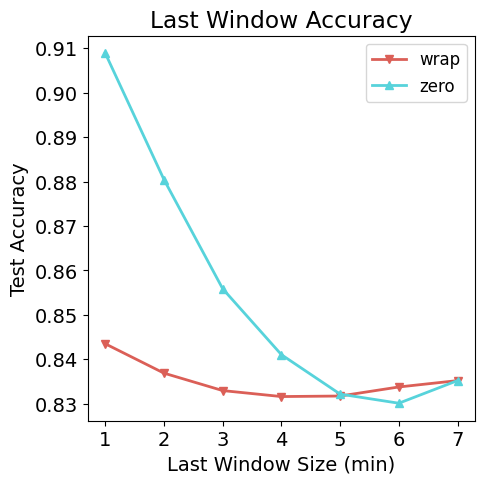

In [204]:
# plot_e2e.plot(xs, ys, line_fmts[0], color=palette[0], ms=6, label="wrap")

# xs_zero = sorted(list(accs_zero.keys()))
# ys_zero = [accs_zero[x] for x in xs_zero]
# plot_e2e.plot(xs_zero, ys_zero, line_fmts[1], color=palette[1], ms=6, label="zero")
# plot_e2e.ax.legend(ncol=1, fontsize=12)
# # save_fig(plot_e2e.fig, "./figures/last_window_acc")

In [13]:
df_all_second_zero["minute_index"] = df_all_second_zero.groupby(["oid", "index", "offset"]).cumcount()

df_all_second_wrap["minute_index"] = df_all_second_wrap.groupby(["oid", "index", "offset"]).cumcount()

In [92]:
cached_dict

{(1,
  'wrap'): ({1: 0.8434841862869495,
   2: 0.8309914313015963,
   3: 0.8251170951015868,
   4: 0.8261979729623886,
   5: 0.8318921628522644,
   6: 0.8417610476682802,
   7: 0.8459122452496202}, {1: {'not-sitting': {'precision': 0.5422869294945198,
     'recall': 0.7344470046082949,
     'f1-score': 0.6239060470893795,
     'support': 22568},
    'sitting': {'precision': 0.9382858437425985,
     'recall': 0.8668962761402774,
     'f1-score': 0.9011794377271715,
     'support': 105106},
    'accuracy': 0.8434841862869495,
    'macro avg': {'precision': 0.7402863866185592,
     'recall': 0.8006716403742862,
     'f1-score': 0.7625427424082755,
     'support': 127674},
    'weighted avg': {'precision': 0.8682880094399946,
     'recall': 0.8434841862869495,
     'f1-score': 0.8521678466443066,
     'support': 127674},
    'bias': 0.15651581371305043,
    'variance': 0.23939878127104972},
   2: {'not-sitting': {'precision': 0.5152957171991842,
     'recall': 0.7389223679546261,
     'f1-

In [94]:
df_all_second_wrap

,segment,timestamp,label,prediction,oid,index,offset,correct,minute_index
0,0,2017-10-02 10:26:40,sitting,sitting,154558,116038,60,True,0
1,0,2017-10-02 10:26:50,sitting,sitting,154558,116038,60,True,1
2,0,2017-10-02 10:27:00,sitting,sitting,154558,116038,60,True,2
3,0,2017-10-02 10:27:10,sitting,sitting,154558,116038,60,True,3
4,0,2017-10-02 10:27:20,sitting,sitting,154558,116038,60,True,4
...,...,...,...,...,...,...,...,...,...
3574867,0,2017-09-20 04:51:00,sitting,sitting,151447,62165,66,True,19
3574868,0,2017-09-20 04:51:10,sitting,sitting,151447,62165,66,True,20
3574869,0,2017-09-20 04:51:20,sitting,sitting,151447,62165,66,True,21
3574870,0,2017-09-20 04:51:30,sitting,sitting,151447,62165,66,True,22


In [14]:
cached_dict = {}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

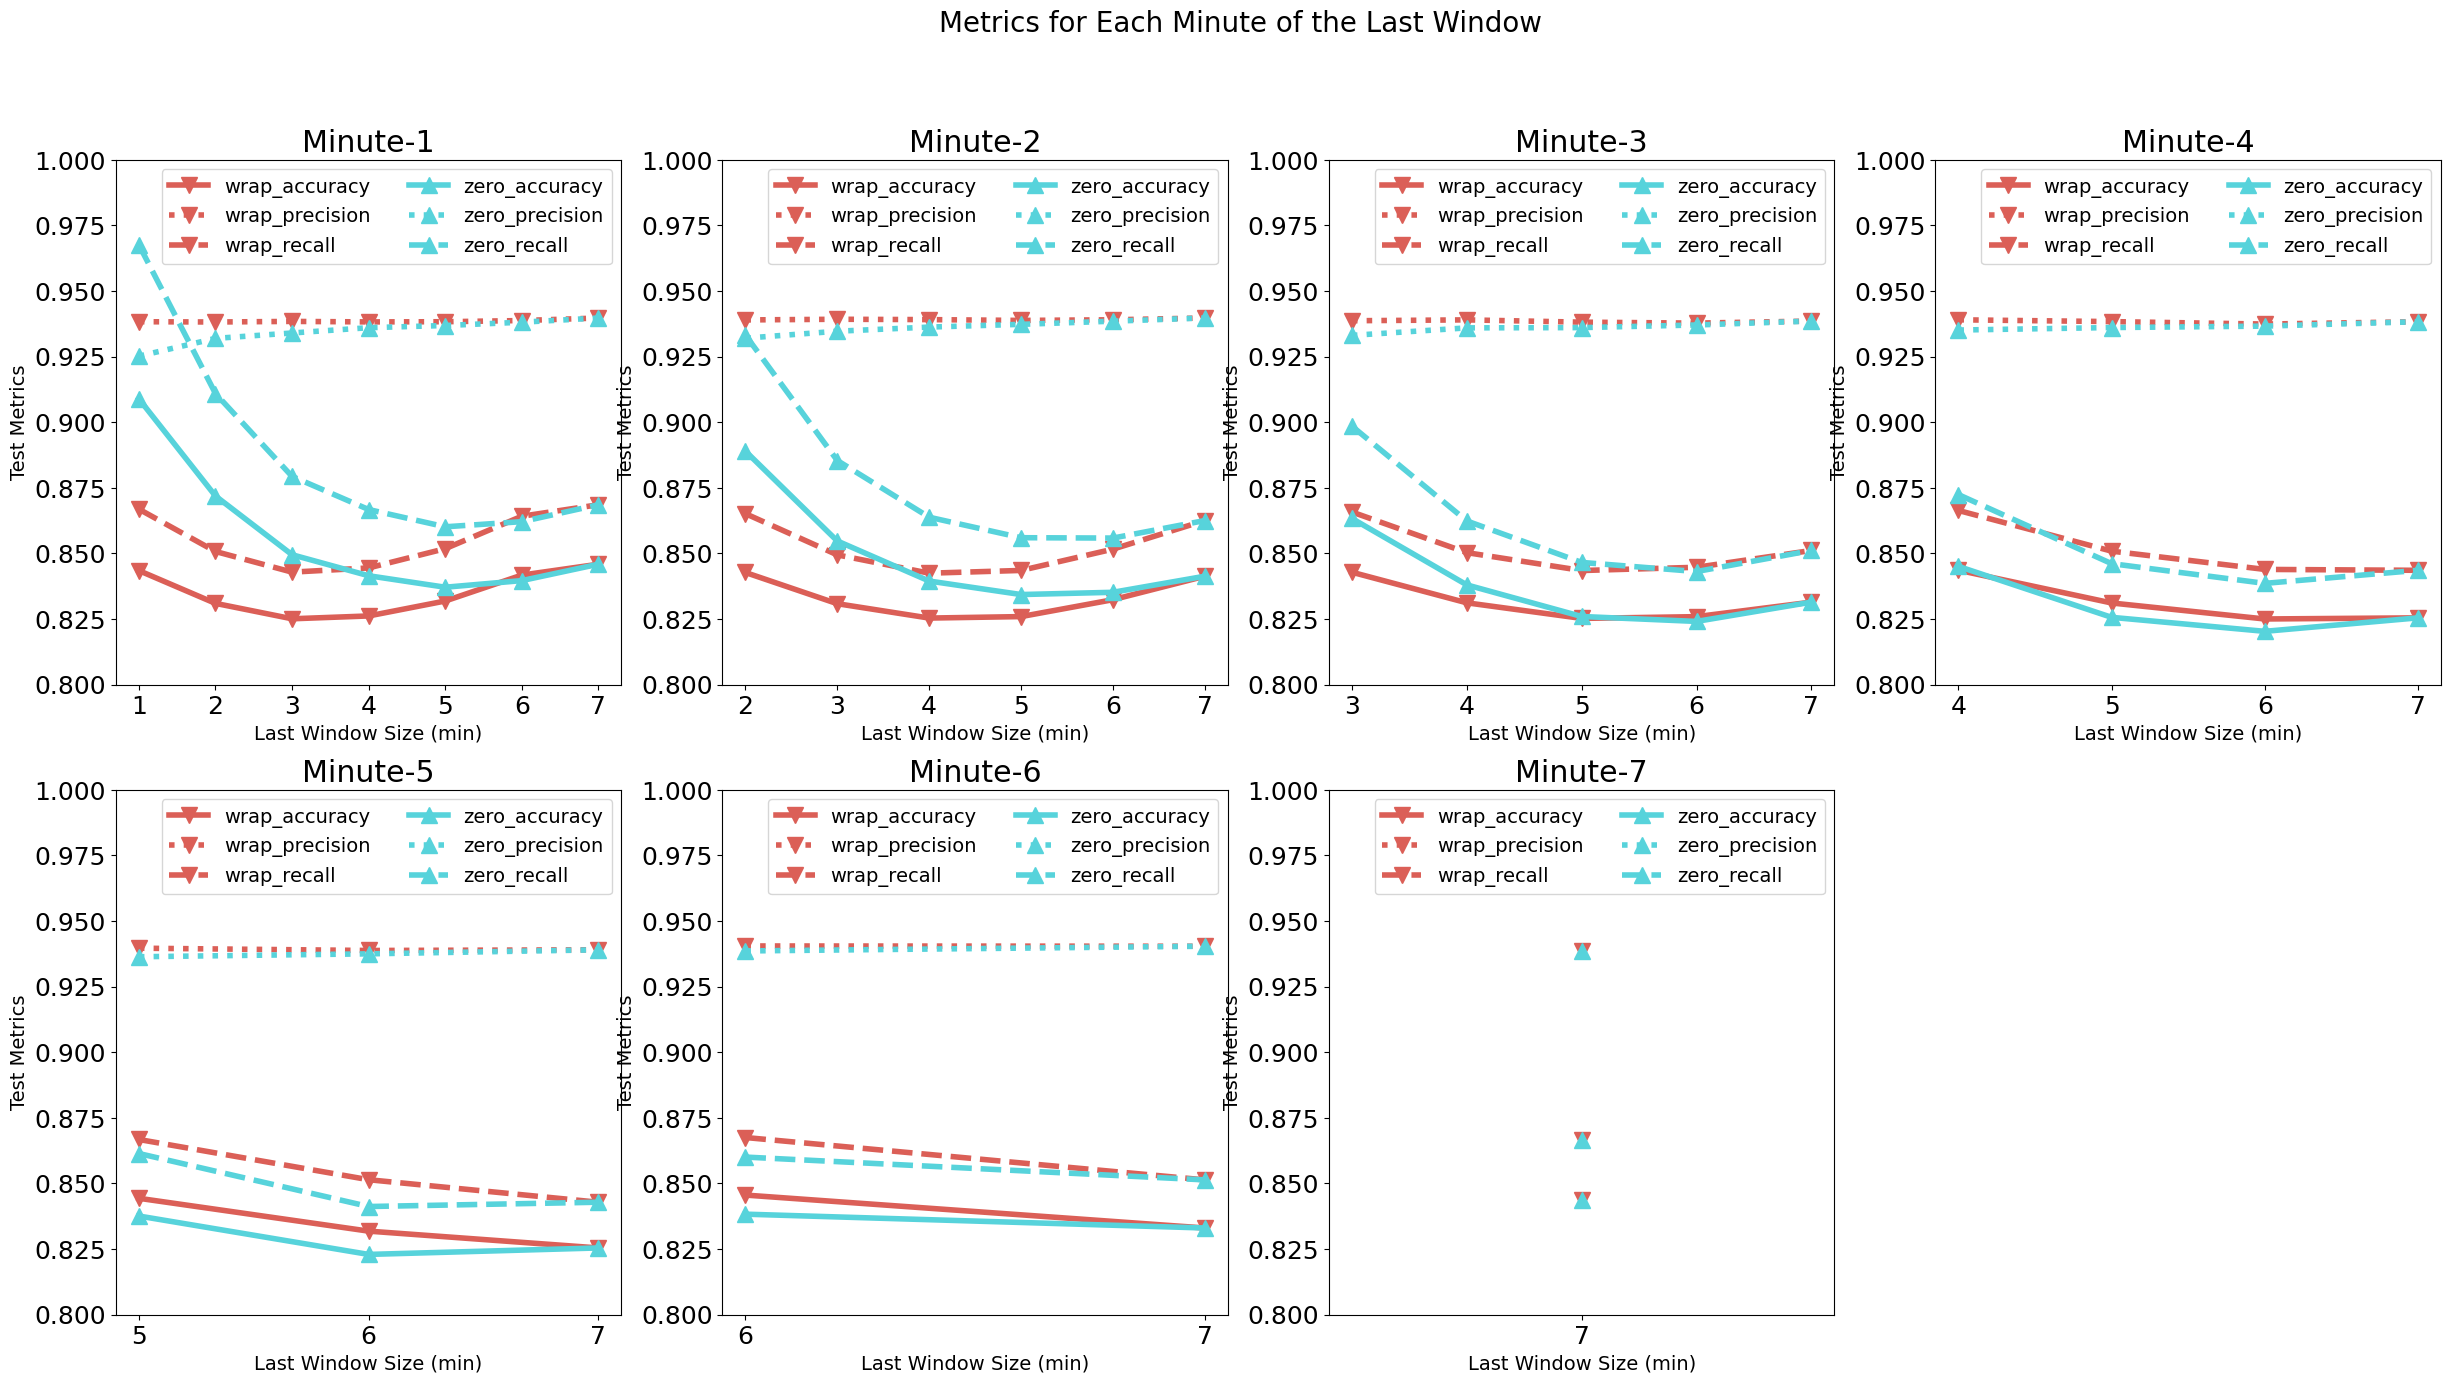

In [46]:
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', 'v--', '^-', '^:', '^--']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
axes[-1][-1].set_axis_off()
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('pdf', fonttype=42)
def get_or_cached(minute, label, df_all_second, cached_dict=cached_dict, force=False):
    if (minute, label) in cached_dict and not force:
        return cached_dict[(minute, label)]
    else:
        accs_min, summaries_min = get_df_min(minute, df_all_second)
        cached_dict[(minute, label)] = accs_min, summaries_min
        return accs_min, summaries_min
    
for minute, ax in zip(np.array([x for x in range(1, 8)]), axes.flatten()):
    i = 0
    for df_all_second, color, label in zip([df_all_second_wrap, df_all_second_zero], palette, ['wrap', 'zero']):
        accs_min, summaries_min = get_or_cached(minute, label, df_all_second, cached_dict=cached_dict)
        xs = sorted(list(summaries_min.keys()))
#         ys = [accs_min[x] for x in xs]
        
        for metric in ["accuracy", "precision", "recall"]:
            if metric == "accuracy":
                ys = [summaries_min[x][metric] for x in xs]
            elif metric == "recall":
                ys = [summaries_min[x]["sitting"][metric] for x in xs]
            elif metric == "precision":
                ys = [summaries_min[x]["sitting"][metric] for x in xs]
            ax.plot(xs, ys, line_fmts[i], linewidth=4, color=color, ms=12, label="{}_{}".format(label, metric))
            i += 1
    
#         ax.plot(xs, ys, fmt, linewidth=4, color=color, ms=12, label=label)
        ax.set_xticks(xs)
        ax.set_xlabel("Last Window Size (min)")
        ax.set_ylabel("Test Metrics")
        ax.set_title("Minute-{}".format(minute))
        ax.legend(ncol=2, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        ax.set_ylim(0.8, 1.0)
#     save_fig(plot_e2e.fig, "./figures/{}".format(name))
fig.suptitle('Metrics for Each Minute of the Last Window', fontsize=20)
save_fig(fig, "./figures/last_window_metrics_per_minute_true")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

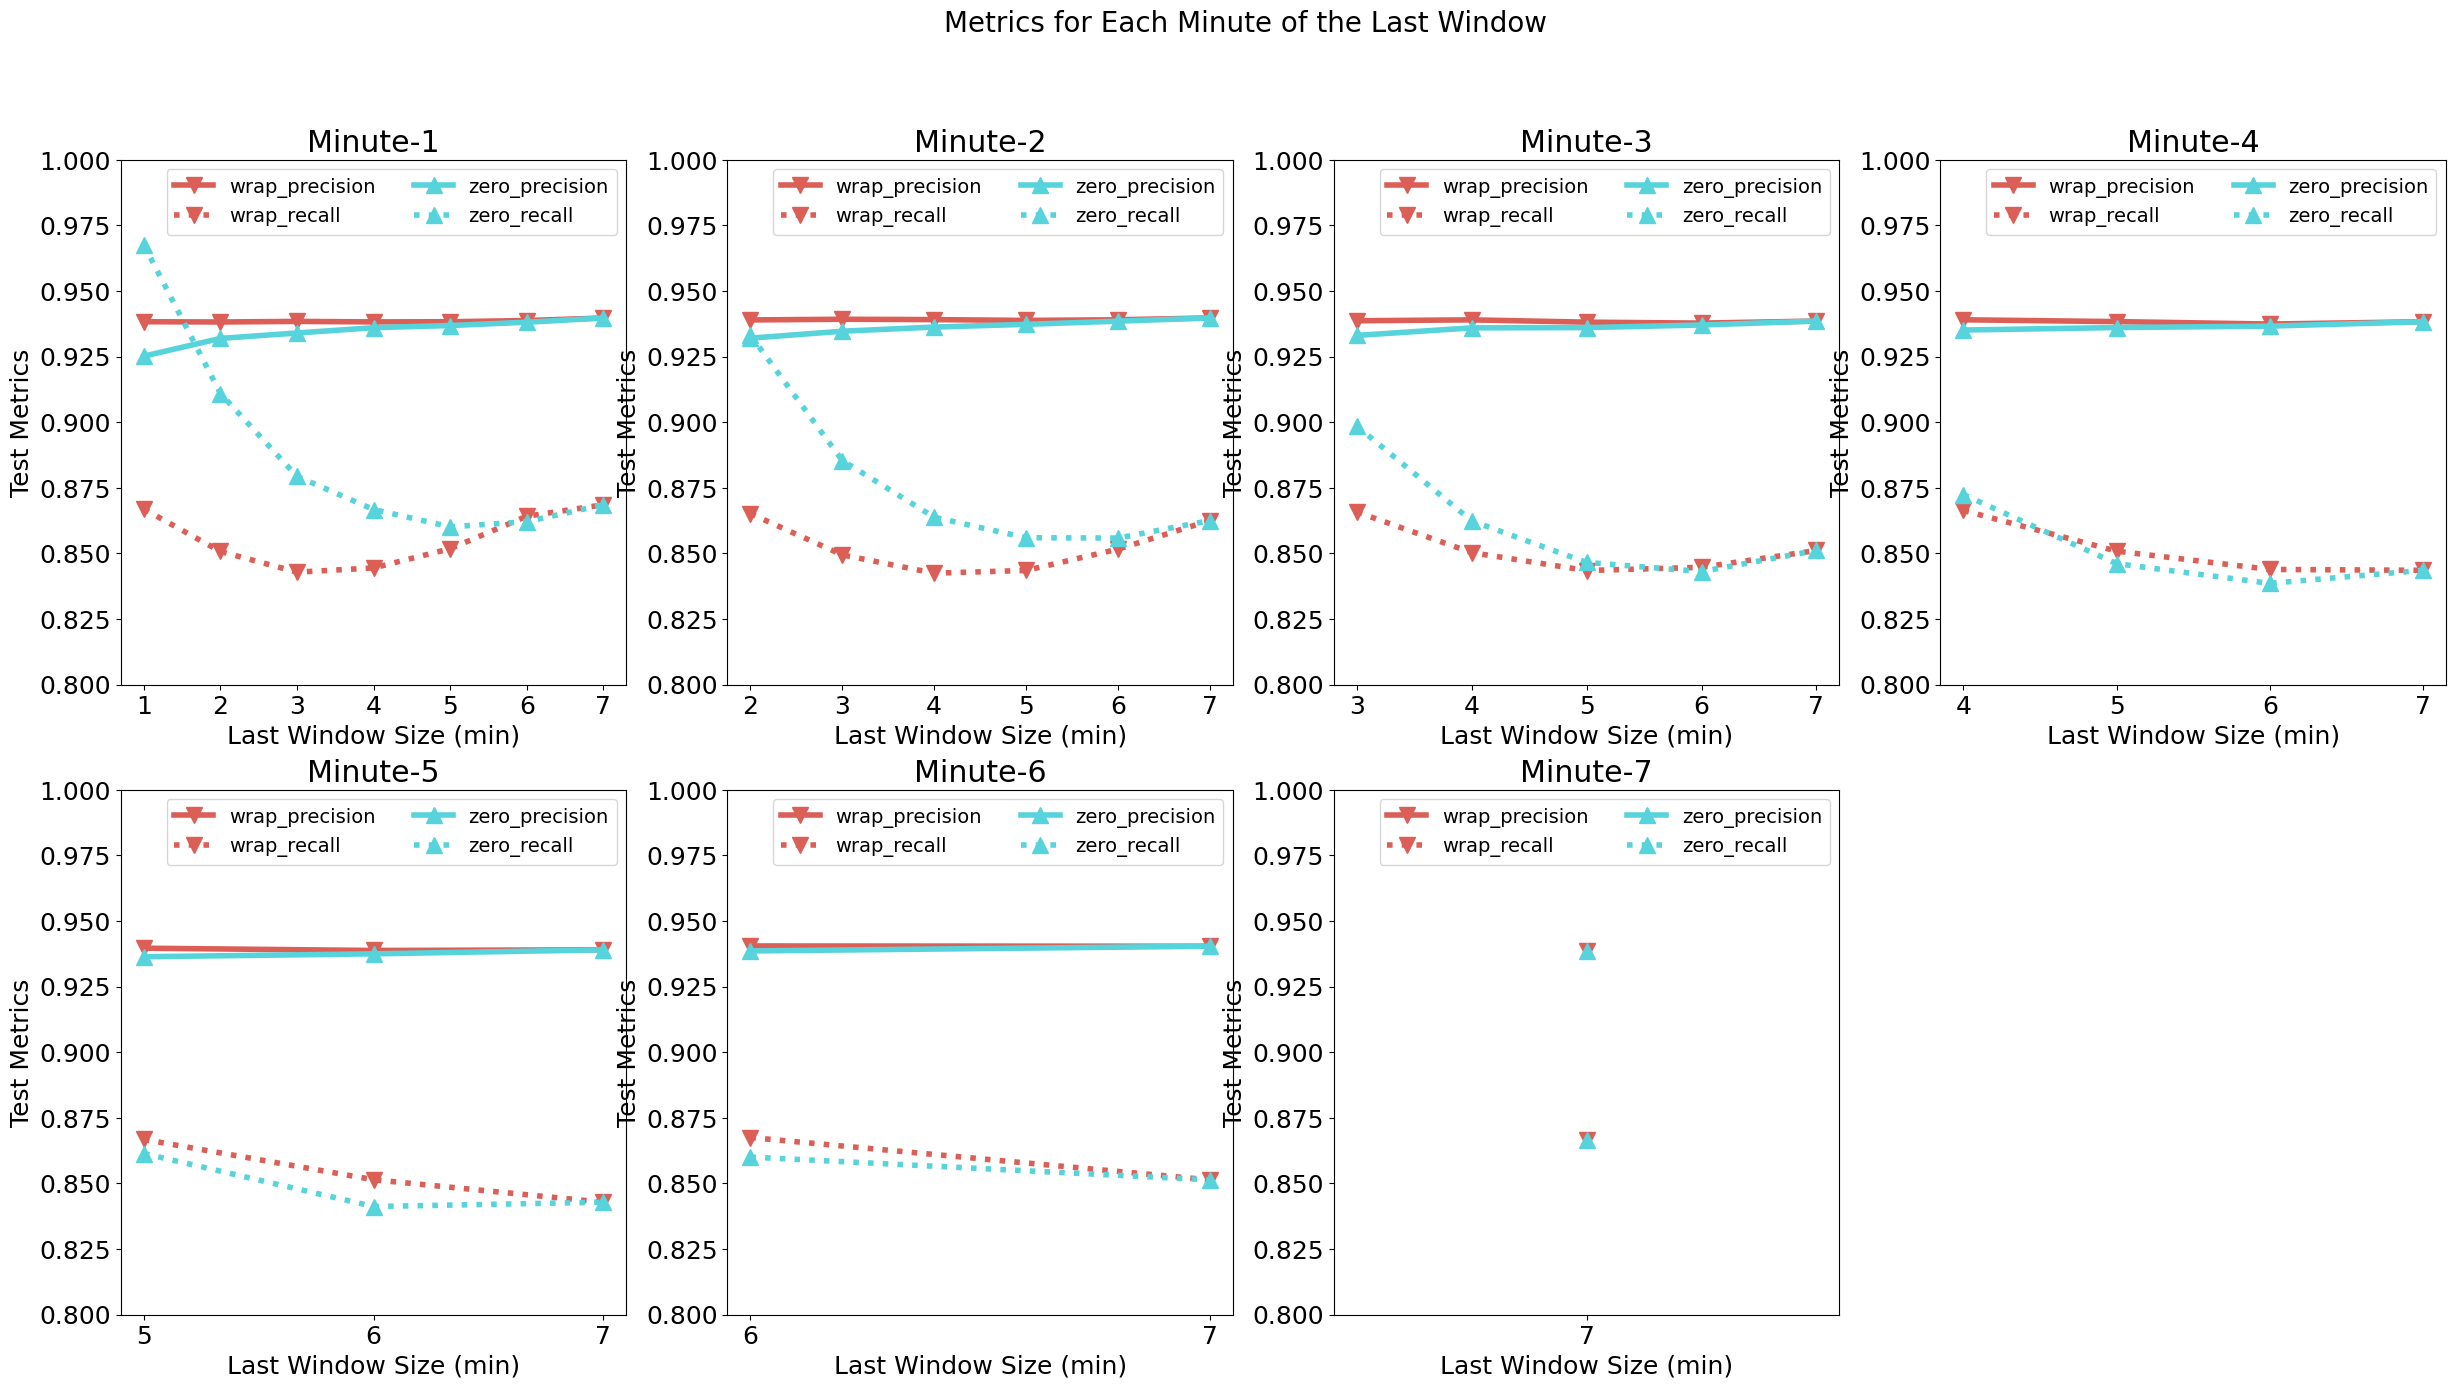

In [74]:
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', '^-', '^:']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
axes[-1][-1].set_axis_off()
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('pdf', fonttype=42)
def get_or_cached(minute, label, df_all_second, cached_dict=cached_dict, force=False):
    if (minute, label) in cached_dict and not force:
        return cached_dict[(minute, label)]
    else:
        accs_min, summaries_min = get_df_min(minute, df_all_second)
        cached_dict[(minute, label)] = accs_min, summaries_min
        return accs_min, summaries_min
    
for minute, ax in zip(np.array([x for x in range(1, 8)]), axes.flatten()):
    i = 0
    for df_all_second, color, label in zip([df_all_second_wrap, df_all_second_zero], palette, ['wrap', 'zero']):
        accs_min, summaries_min = get_or_cached(minute, label, df_all_second, cached_dict=cached_dict)
        xs = sorted(list(summaries_min.keys()))
#         ys = [accs_min[x] for x in xs]
        
        for metric in ["precision", "recall"]:
            if metric == "recall":
                ys = [summaries_min[x]["sitting"][metric] for x in xs]
            elif metric == "precision":
                ys = [summaries_min[x]["sitting"][metric] for x in xs]
            ax.plot(xs, ys, line_fmts[i], linewidth=4, color=color, ms=12, label="{}_{}".format(label, metric))
            i += 1
    
#         ax.plot(xs, ys, fmt, linewidth=4, color=color, ms=12, label=label)
        ax.set_xticks(xs)
        ax.set_xlabel("Last Window Size (min)")
        ax.set_ylabel("Test Metrics")
        ax.set_title("Minute-{}".format(minute))
        ax.legend(ncol=2, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        ax.set_ylim(0.8, 1.0)
#     save_fig(plot_e2e.fig, "./figures/{}".format(name))
fig.suptitle('Metrics for Each Minute of the Last Window', fontsize=20)
save_fig(fig, "./figures/last_window_pr_per_minute")

In [ ]:
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', '^-', '^:']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
axes[-1][-1].set_axis_off()
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('pdf', fonttype=42)
def get_or_cached(minute, label, df_all_second, cached_dict=cached_dict, force=False):
    if (minute, label) in cached_dict and not force:
        return cached_dict[(minute, label)]
    else:
        accs_min, summaries_min = get_df_min(minute, df_all_second)
        cached_dict[(minute, label)] = accs_min, summaries_min
        return accs_min, summaries_min
    
for minute, ax in zip(np.array([x for x in range(1, 8)]), axes.flatten()):
    i = 0
    for df_all_second, color, label in zip([df_all_second_wrap, df_all_second_zero], palette, ['wrap', 'zero']):
        accs_min, summaries_min = get_or_cached(minute, label, df_all_second, cached_dict=cached_dict)
        xs = sorted(list(summaries_min.keys()))
#         ys = [accs_min[x] for x in xs]
        
        for metric in ["acc", "balanced_acc"]:
            if metric == "balanced_acc":
                ys = [((summaries_min[x]["sitting"]["recall"] + summaries_min[x]["not-sitting"]["recall"]) / 2) for x in xs]
            elif metric == "acc":
                ys = [summaries_min[x]["accuracy"] for x in xs]
            ax.plot(xs, ys, line_fmts[i], linewidth=4, color=color, ms=12, label="{}_{}".format(label, metric))
            i += 1
    
#         ax.plot(xs, ys, fmt, linewidth=4, color=color, ms=12, label=label)
        ax.set_xticks(xs)
        ax.set_xlabel("Last Window Size (min)")
        ax.set_ylabel("Test Metrics")
        ax.set_title("Minute-{}".format(minute))
        ax.legend(ncol=1, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        ax.set_ylim(0.78, 0.95)
#     save_fig(plot_e2e.fig, "./figures/{}".format(name))
fig.suptitle('Metrics for Each Minute of the Last Window', fontsize=20)
save_fig(fig, "./figures/last_window_acc_per_minute")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

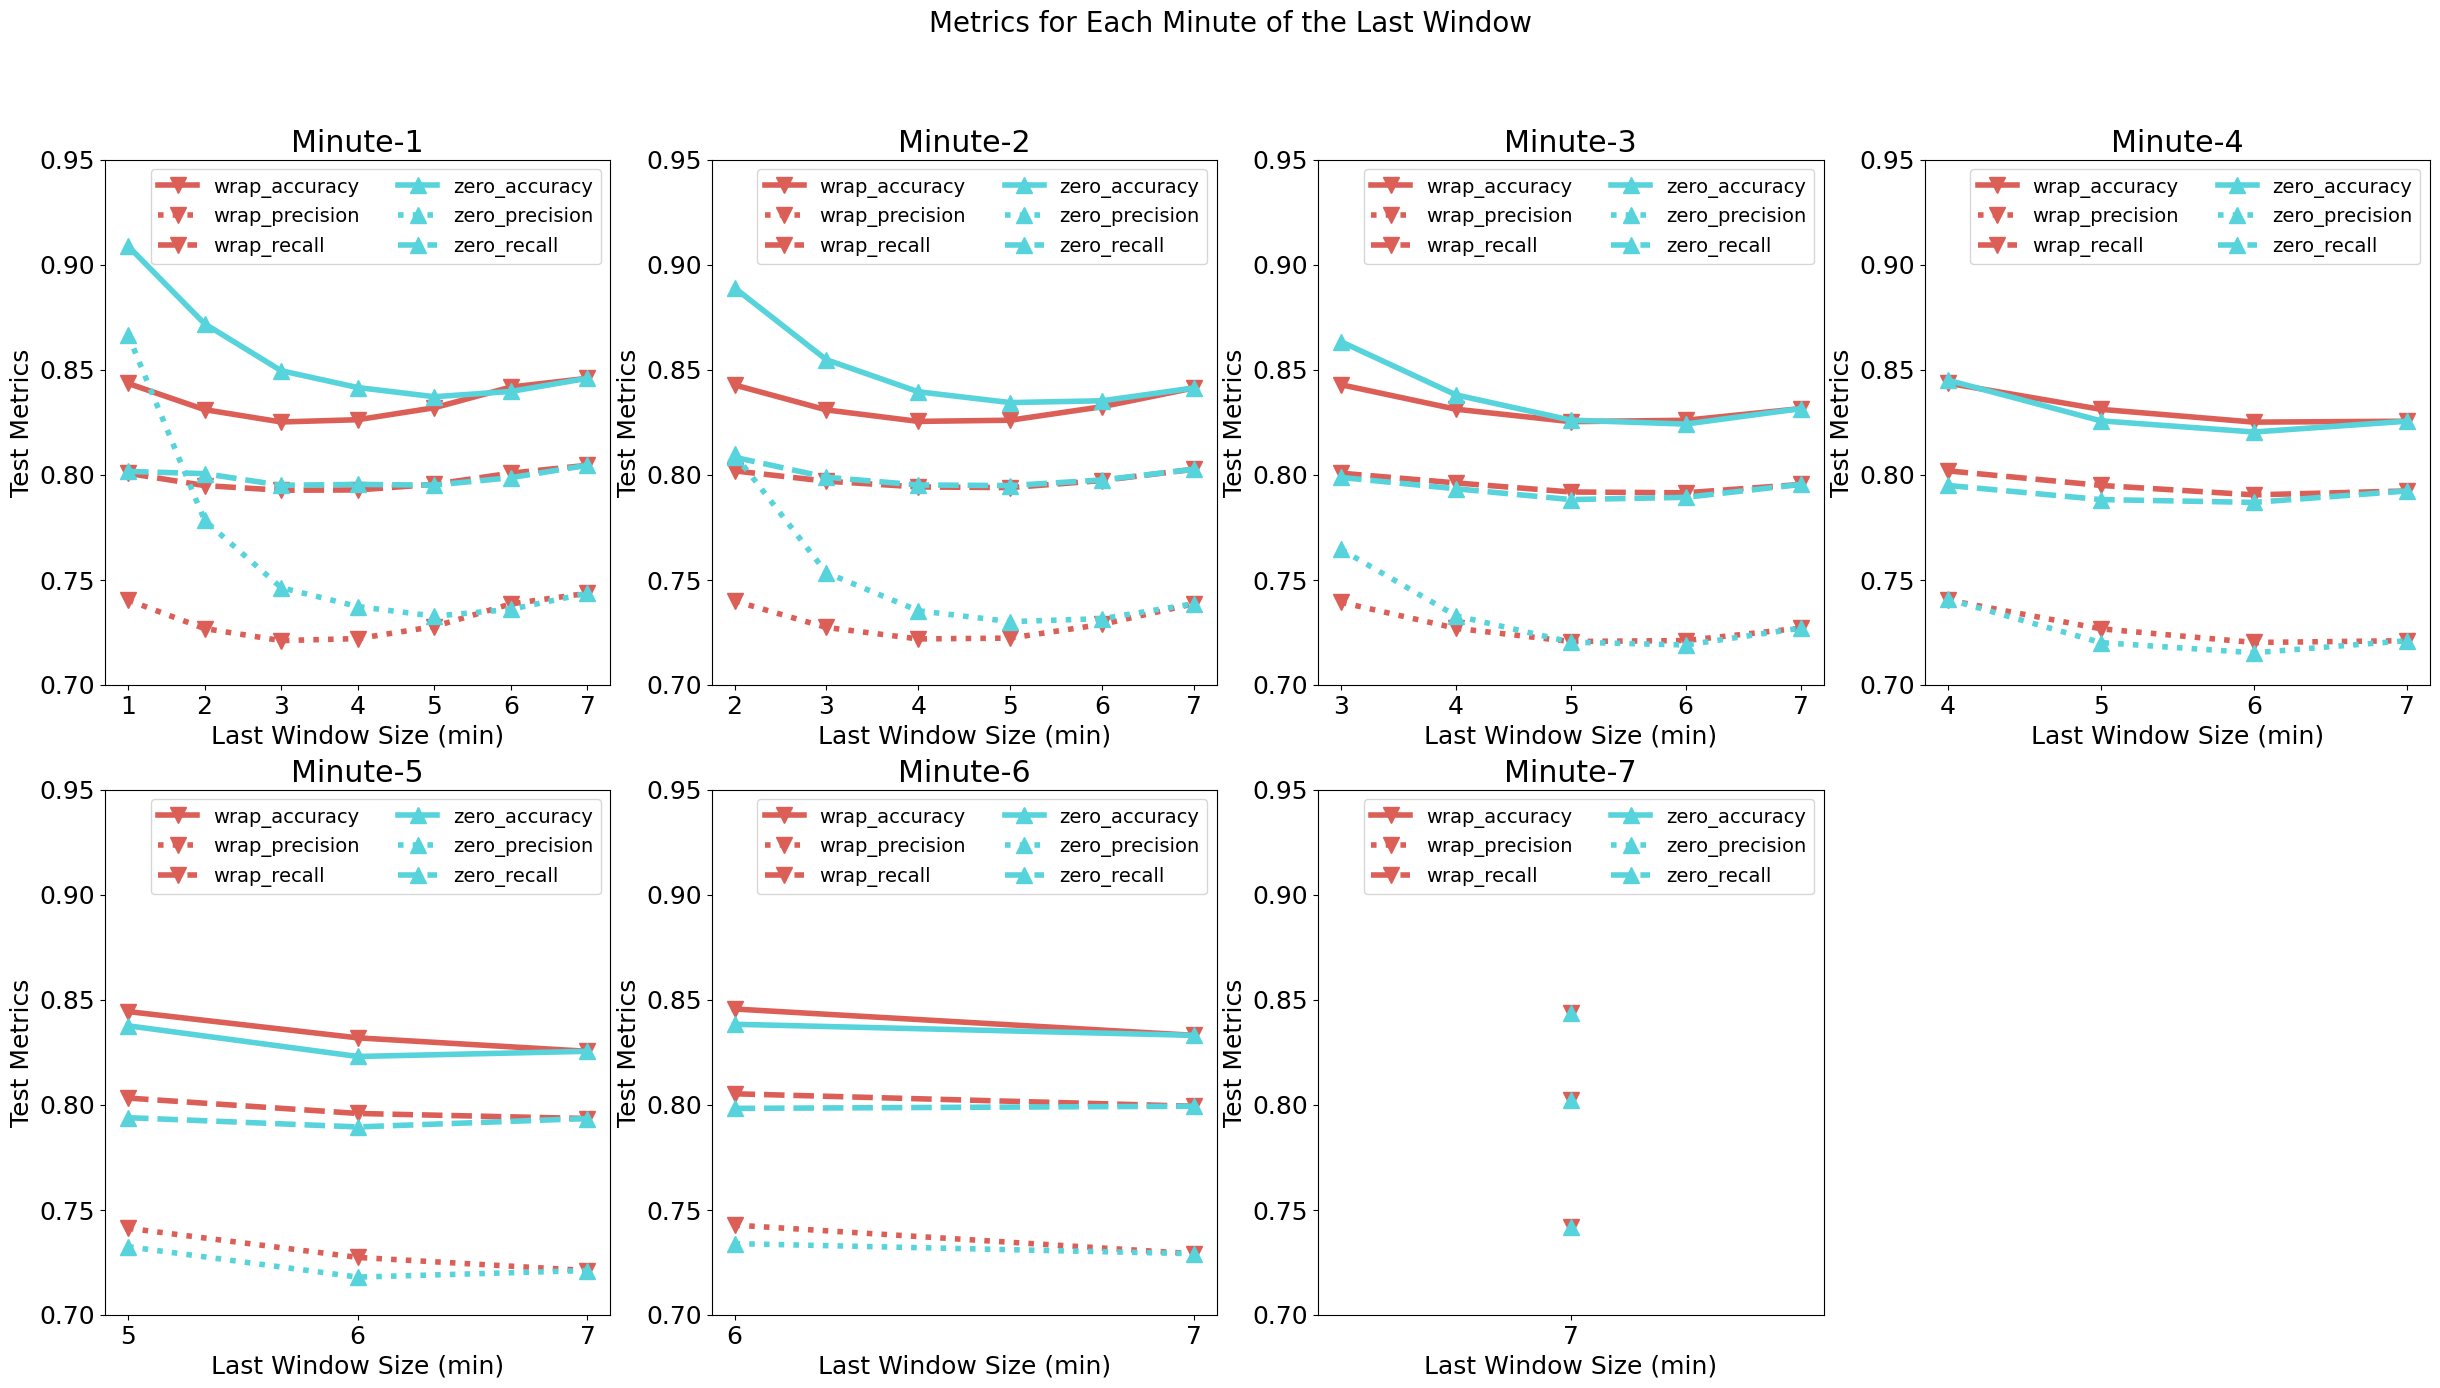

In [96]:
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
line_fmts = ['v-', 'v:', 'v--', '^-', '^:', '^--']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
axes[-1][-1].set_axis_off()
matplotlib.rcParams.update({'font.size': 18})
matplotlib.rc('pdf', fonttype=42)
cached_dict = {}
def get_or_cached(minute, label, df_all_second, cached_dict=cached_dict, force=False):
    if (minute, label) in cached_dict and not force:
        return cached_dict[(minute, label)]
    else:
        accs_min, summaries_min = get_df_min(minute, df_all_second)
        cached_dict[(minute, label)] = accs_min, summaries_min
        return accs_min, summaries_min
    
for minute, ax in zip(np.array([x for x in range(1, 8)]), axes.flatten()):
    i = 0
    for df_all_second, color, label in zip([df_all_second_wrap, df_all_second_zero], palette, ['wrap', 'zero']):
        accs_min, summaries_min = get_or_cached(minute, label, df_all_second, cached_dict=cached_dict)
        xs = sorted(list(summaries_min.keys()))
#         ys = [accs_min[x] for x in xs]
        
        for metric in ["accuracy", "precision", "recall"]:
            if metric == "accuracy":
                ys = [summaries_min[x][metric] for x in xs]
            else:
                ys = [summaries_min[x]["macro avg"][metric] for x in xs]
            ax.plot(xs, ys, line_fmts[i], linewidth=4, color=color, ms=12, label="{}_{}".format(label, metric))
            i += 1
    
#         ax.plot(xs, ys, fmt, linewidth=4, color=color, ms=12, label=label)
        ax.set_xticks(xs)
        ax.set_xlabel("Last Window Size (min)")
        ax.set_ylabel("Test Metrics")
        ax.set_title("Minute-{}".format(minute))
        ax.legend(ncol=2, fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.tick_params(axis='both', which='minor', labelsize=16)
        ax.set_ylim(0.7, 0.95)
#     save_fig(plot_e2e.fig, "./figures/{}".format(name))
fig.suptitle('Metrics for Each Minute of the Last Window', fontsize=20)
save_fig(fig, "./figures/last_window_metrics_per_minute")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

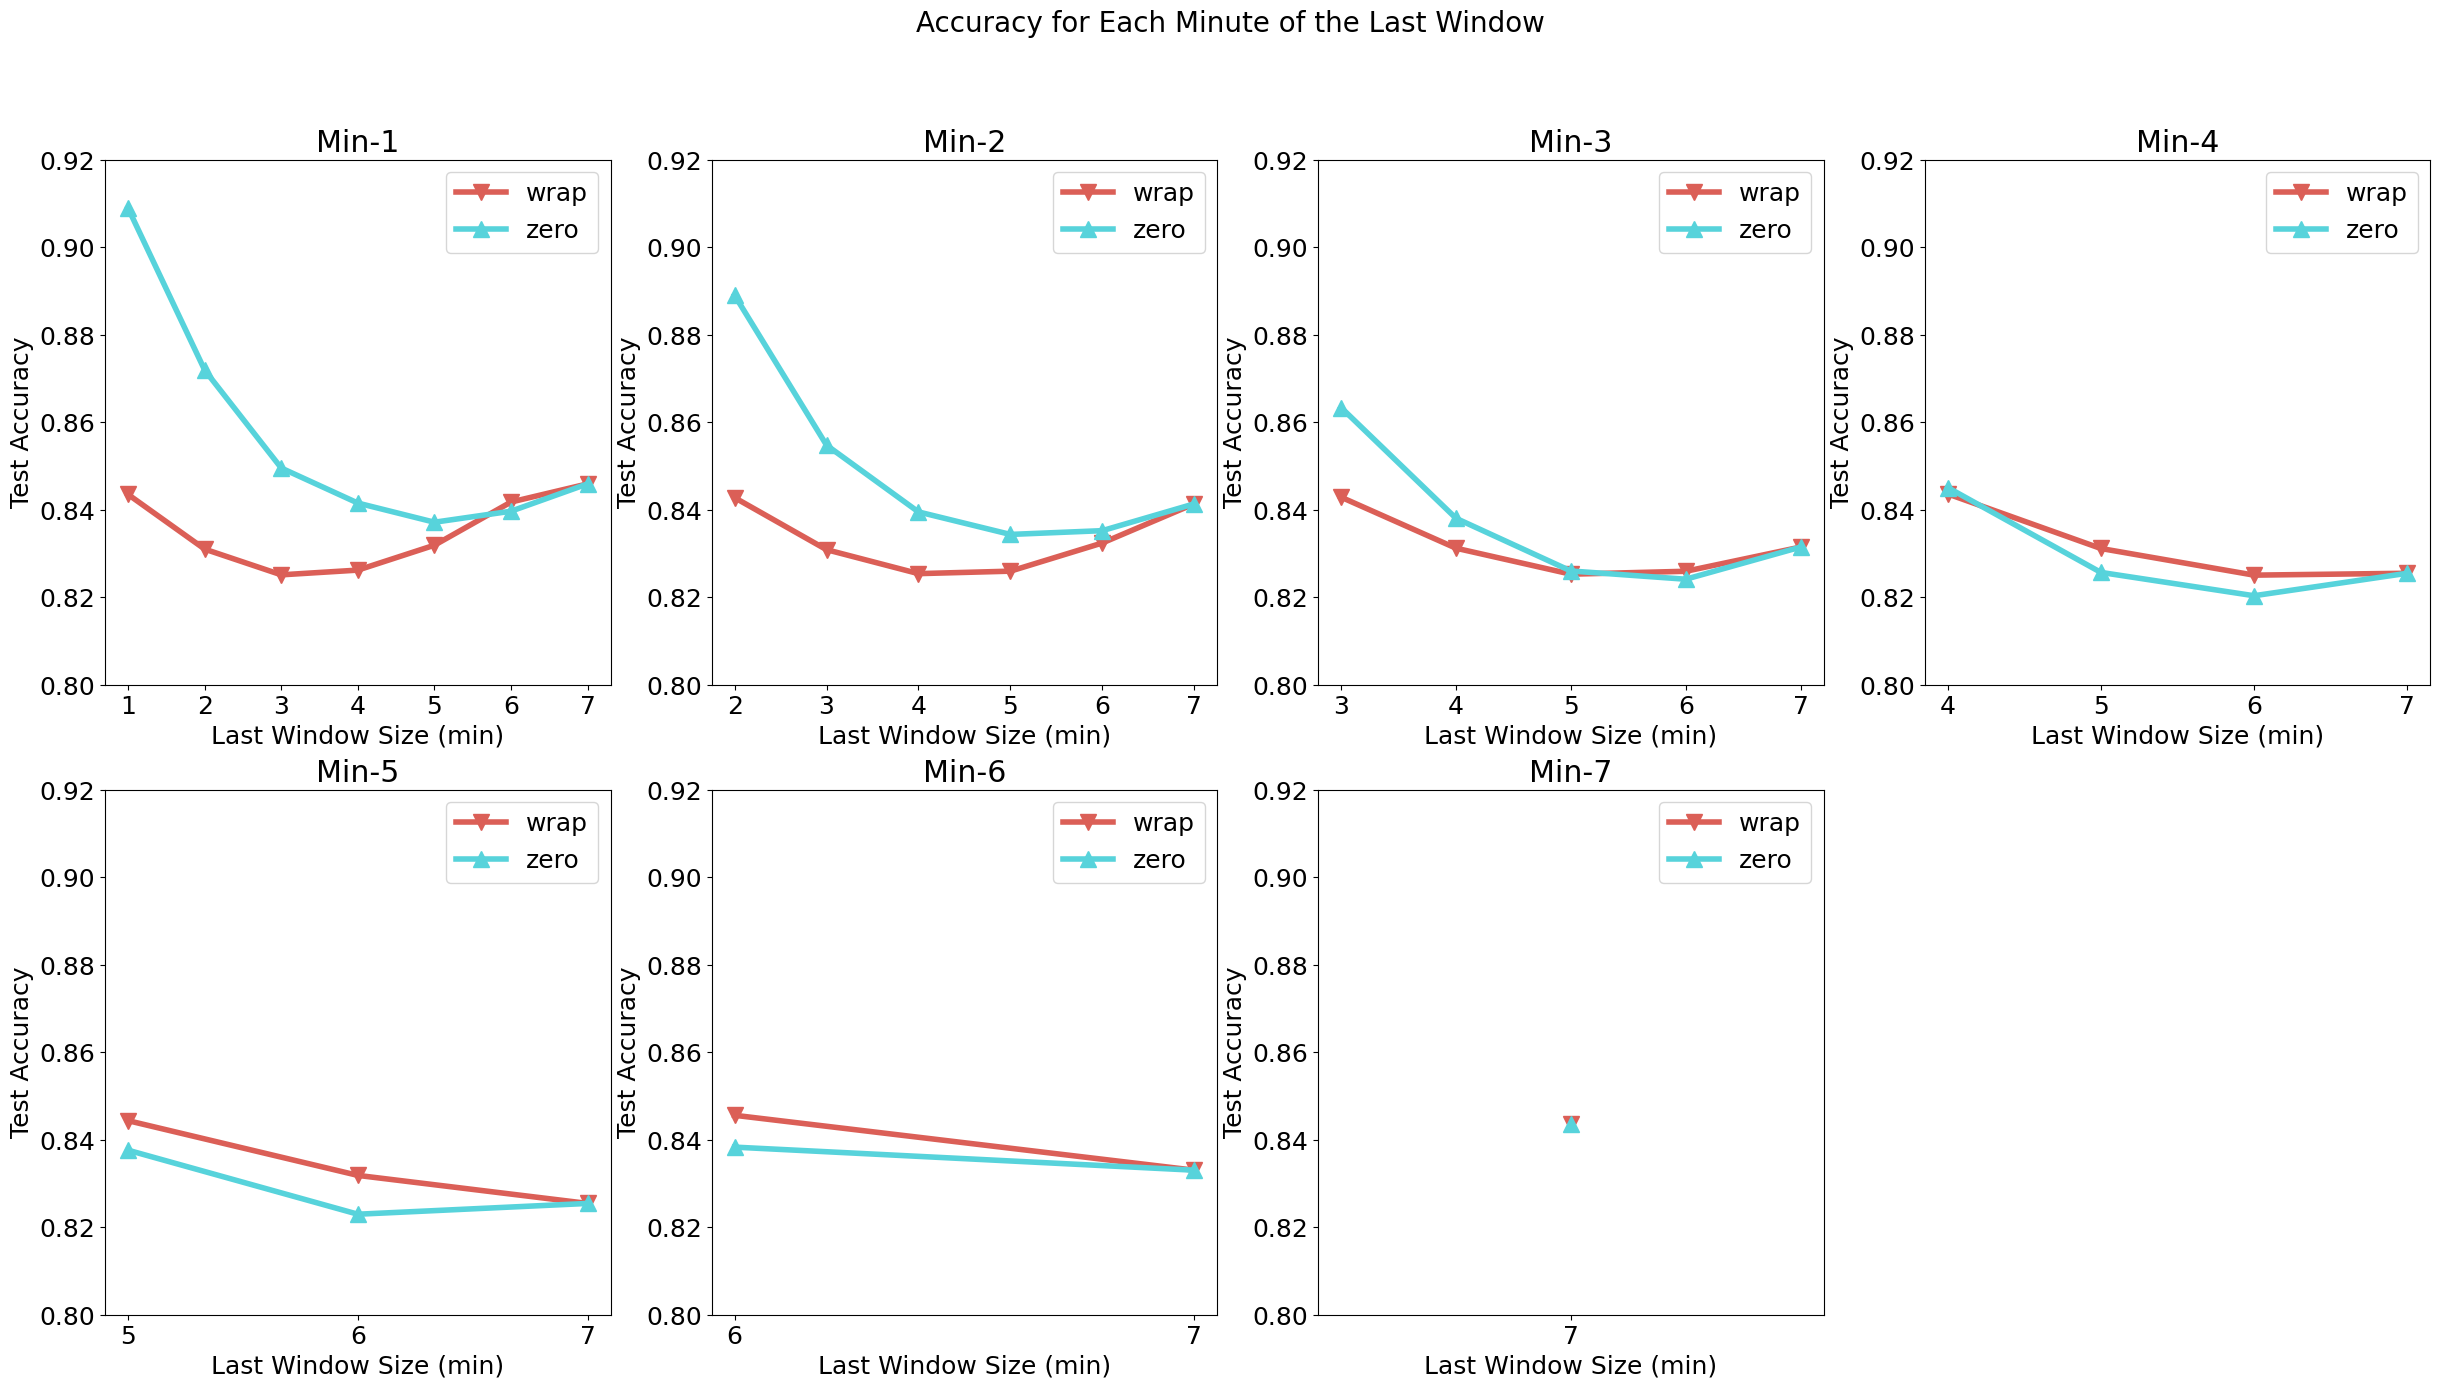

In [200]:
# palette = sns.color_palette("hls", 2)
# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)
# line_fmts = ['v-', '^-']
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 15))
# axes[-1][-1].set_axis_off()
# matplotlib.rcParams.update({'font.size': 18})
# matplotlib.rc('pdf', fonttype=42)
# for minute, ax in zip(np.array([x for x in range(1, 8)]), axes.flatten()):
# #     plot_e2e = PlotterBase(xlabel='Last Window Size (min)',
# #                                ylabel='Test Accuracy',
# #                                title='Last Window Min-{} Accuracy'.format(minute),
# #                                set_ticks=True)
# #     name = "last_window_acc_{}".format(minute)
#     for df_all_second, color, fmt, label in zip([df_all_second_wrap, df_all_second_zero], palette, line_fmts, ['wrap', 'zero']):
#         accs_min = get_df_min(minute, df_all_second)
#         xs = sorted(list(accs_min.keys()))
#         ys = [accs_min[x] for x in xs]

#         ax.plot(xs, ys, fmt, linewidth=4, color=color, ms=12, label=label)
#         ax.set_xticks(xs)
#         ax.set_xlabel("Last Window Size (min)")
#         ax.set_ylabel("Test Accuracy")
#         ax.set_title("Min-{}".format(minute))
#         ax.legend(ncol=1, fontsize=18)
#         ax.tick_params(axis='both', which='major', labelsize=18)
#         ax.tick_params(axis='both', which='minor', labelsize=16)
#         ax.set_ylim(0.8, 0.92)
# #     save_fig(plot_e2e.fig, "./figures/{}".format(name))
# fig.suptitle('Accuracy for Each Minute of the Last Window', fontsize=20)
# save_fig(fig, "./figures/last_window_acc_per_minute")

In [189]:
fig.suptitle('Last Window Accuracy Per Minute', fontsize=16)

Text(0.5, 0.98, 'Last Window Accuracy Per Minute')